In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from imblearn.over_sampling import KMeansSMOTE as SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

metrics_data_columns = ['k_neighbour', 'train_accuracy', 'test_accuracy', 'roc_auc',
                         'precision_0', 'recall_0', 'f1_0',
                         'precision_1', 'recall_1', 'f1_1', 
                         'ks_stat', 'p_value', 
                         'tp', 'tn', 'fp', 'fn']

In [ ]:
from imblearn.ensemble import 

### Reading data

In [2]:
# File location of the dataset
data_loc = "./Churn_Modelling.csv"

# Read the CSV file into a Pandas DataFrame, using the first column as the index
df = pd.read_csv(data_loc, index_col=0)

df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Unique values in each column

In [5]:
for idx,column in enumerate(df.columns):
    # Get the unique values in the current column
    unique_values = df[column].unique()
    
    print("{}. {:<20} :: Unique value count :: {:<10}".format(idx,column, len(unique_values)), end='')
    
    # If the number of unique values is less than 15
    if len(unique_values) < 15:
        print(f" :: {sorted(unique_values)}")
        
    # If the number of unique values is greater than or equal to 15, don't display the values
    else:
        print()

0. CustomerId           :: Unique value count :: 10000     
1. Surname              :: Unique value count :: 2932      
2. CreditScore          :: Unique value count :: 460       
3. Geography            :: Unique value count :: 3          :: ['France', 'Germany', 'Spain']
4. Gender               :: Unique value count :: 2          :: ['Female', 'Male']
5. Age                  :: Unique value count :: 70        
6. Tenure               :: Unique value count :: 11         :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
7. Balance              :: Unique value count :: 6382      
8. NumOfProducts        :: Unique value count :: 4          :: [1, 2, 3, 4]
9. HasCrCard            :: Unique value count :: 2          :: [0, 1]
10. IsActiveMember       :: Unique value count :: 2          :: [0, 1]
11. EstimatedSalary      :: Unique value count :: 9999      
12. Exited               :: Unique value count :: 2          :: [0, 1]


# Basic understanding about dataset

- RowNumber: the index of the row in the dataset
- CustomerId: a unique identifier for each customer
- CreditScore: the customer's credit score
- Age: the customer's age
- Tenure: the number of years the customer has been with the bank
- Balance: the customer's account balance
- NumOfProducts: the number of bank products the customer has
- HasCrCard: whether the customer has a credit card with the bank (1=yes, 0=no)
- IsActiveMember: whether the customer is an active member of the bank (1=yes, 0=no)
- EstimatedSalary: the customer's estimated salary
- Exited: whether the customer has churned (left the bank) (1=yes, 0=no)

## Class Distribution

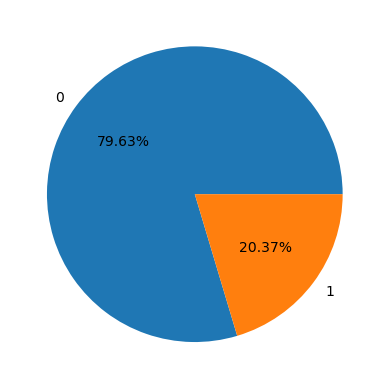

In [6]:
plt.pie(df["Exited"].value_counts(), 
        labels=sorted(df['Exited'].unique()),
        autopct='%1.2f%%')
plt.show()

## Correlation Matrix

<Axes: >

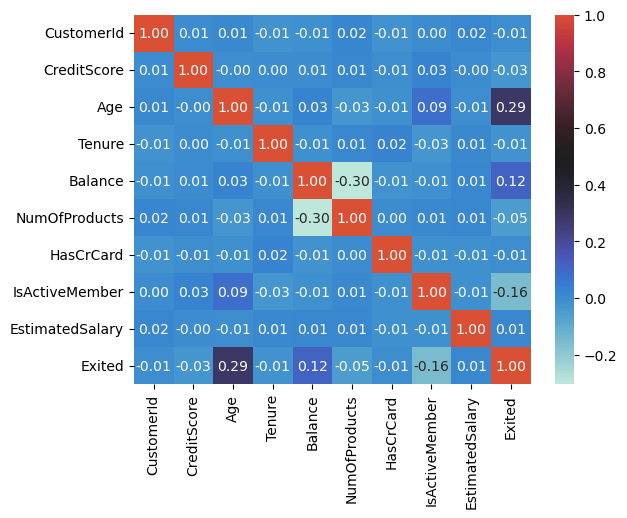

In [7]:
sns.heatmap(df[df.describe().columns].corr(),
            annot=True,
            fmt='.2f',
            center=0.5)

### Drop all categorical columns

In [3]:
df.drop(['CustomerId', 'Surname','Geography', 'Gender'], axis = 1,inplace=True)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1
2,608,41,1,83807.86,1,0,1,112542.58,0
3,502,42,8,159660.80,3,1,0,113931.57,1
4,699,39,1,0.00,2,0,0,93826.63,0
5,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9996,771,39,5,0.00,2,1,0,96270.64,0
9997,516,35,10,57369.61,1,1,1,101699.77,0
9998,709,36,7,0.00,1,0,1,42085.58,1


## Functions for model training and evaluation

In [4]:
def features_target_split(df, target_col='Exited'):
    """
    Split the DataFrame into features and target variables.
    
    Parameters:
        df (DataFrame): The input DataFrame.
        target_col (str): The name of the target column. Default is 'Exited'.
        
    Returns:
        x (DataFrame): The features.
        y (Series): The target variable.
    """
    # Drop the target column from the DataFrame to get the features
    x = df.drop(target_col, axis=1)
    
    # Assign the target column as the y variable
    y = df[target_col]
    
    # Return the features and target variables
    return x,y


def train_test_split(x,y,df,target_col='Exited', test_size=0.2, random_state=42):
    """
    Split the features and target variables into training and testing sets.
    
    Parameters:
        x (DataFrame): The features.
        y (Series): The target variable.
        df (DataFrame): The original DataFrame.
        target_col (str): The name of the target column. Default is 'Exited'.
        test_size (float or int): The proportion or absolute number of samples to include in the testing set. Default is 0.2.
        random_state (int): The seed used by the random number generator. Default is 42.
        
    Returns:
        x_train (DataFrame): The training set features.
        x_test (DataFrame): The testing set features.
        y_train (Series): The training set target variable.
        y_test (Series): The testing set target variable.
    """
    from sklearn.model_selection import train_test_split
    
    # Split the features and target variables into training and testing sets
    # Stratified is being used to maintain the proportion of class [0 and 1] in splits.
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state, 
                                                        stratify=df[target_col])
    
    return x_train, x_test, y_train, y_test

def logistic_model_train(x_train, y_train, random_state=42, max_iter=1000):
    """
    Train a logistic regression model using the provided training data.
    
    Parameters:
        x_train (DataFrame): The training set features.
        y_train (Series): The training set target variable.
        random_state (int): The seed used by the random number generator. Default is 42.
        max_iter (int): The maximum number of iterations for the solver to converge. Default is 1000.
        
    Returns:
        log_reg_model (LogisticRegression): The trained logistic regression model.
    """
    
    # Create an instance of LogisticRegression model with specified random_state and max_iter
    log_reg_model = LogisticRegression(random_state=random_state, max_iter=max_iter)
    
    # Fit the logistic regression model to the training data
    log_reg_model.fit(x_train, y_train)
    
    return log_reg_model

def prediction(log_reg_model, x_train, x_test):
    """
    Generate predictions using a trained logistic regression model.
    
    Parameters:
        log_reg_model (LogisticRegression): The trained logistic regression model.
        x_train (array-like or sparse matrix): The training set features.
        x_test (array-like or sparse matrix): The testing set features.
        
    Returns:
        y_pred_train (array-like): Predicted labels for the training set.
        y_pred_test (array-like): Predicted labels for the testing set.
        y_pred_test_proba (array-like): Predicted probabilities for the testing set.
    """
    # Generate predictions for the training set
    y_pred_train = log_reg_model.predict(x_train)
    
    # Generate predictions for the testing set
    y_pred_test = log_reg_model.predict(x_test)
    
    # Generate predicted probabilities for the testing set
    y_pred_test_proba = log_reg_model.predict_proba(x_test)
    
    return y_pred_train, y_pred_test, y_pred_test_proba


class Evaluation():
    def __init__(self,y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba):
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = y_pred_train
        self.y_pred_test = y_pred_test
        self.y_pred_test_proba = y_pred_test_proba
    
    def __ks_stats_value__(self):
        """
        Calculate the Kolmogorov-Smirnov (KS) statistic and p-value.
        
        Returns:
            ks_stat (float): The KS statistic.
            p_value (float): The p-value.
        """
        
        # proba_non_churn contains the predicted probabilities for instances that did not churn
        proba_non_churn = self.y_pred_test_proba[:,1][self.y_test==0]
        
        # proba_churn contains the predicted probabilities for instances that actually churned
        proba_churn = self.y_pred_test_proba[:,1][self.y_test==1]
        
        # Calculating Kolmogorov-Smirnov (KS) statistic and p-value
        ks_stat, p_value = ks_2samp(proba_non_churn, proba_churn)
        return ks_stat, p_value
    
    def __accuracy_value__(self):
        train_accuracy = accuracy_score(self.y_train, self.y_pred_train)
        test_accuracy = accuracy_score(self.y_test, self.y_pred_test)
        return train_accuracy, test_accuracy

    def __prec_rec_f1_value__(self, pos_label):
        """
        Calculate precision, recall, and F1-score for a given label.
        
        Parameters:
            pos_label: The label for which metrics are calculated.
        
        Returns:
            precision (float): Precision score.
            recall (float): Recall score.
            f1 (float): F1-score.
        """
        precision = precision_score(self.y_test, self.y_pred_test,pos_label=pos_label)
        recall = recall_score(self.y_test, self.y_pred_test,pos_label=pos_label)
        f1 = f1_score(self.y_test, self.y_pred_test, pos_label=pos_label)
        return precision, recall, f1

    def __roc_value__(self):
        roc_auc = roc_auc_score(self.y_test, self.y_pred_test)
        return roc_auc

    def __confusion_matrix_value__(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred_test).ravel()
        return tn, fp, fn, tp
    
    def main(self):
        train_accuracy, test_accuracy = self.__accuracy_value__()
        
        precision_0, recall_0, f1_0 = self.__prec_rec_f1_value__(pos_label=0)
        precision_1, recall_1, f1_1 = self.__prec_rec_f1_value__(pos_label=1)
        
        ks_stat, p_value = self.__ks_stats_value__()
        
        roc_auc = self.__roc_value__()
        
        tn, fp, fn, tp = self.__confusion_matrix_value__()
        
        all_metrics = [train_accuracy, test_accuracy, roc_auc, 
                       precision_0, recall_0, f1_0, 
                       precision_1, recall_1, f1_1, 
                       ks_stat, p_value, 
                       tp, tn, fp, fn]
        
        all_metrics = [round(value, ndigits=6) for value in all_metrics]
        all_metrics_dict = {'train_acc':all_metrics[0], 'test_acc':all_metrics[1], 'roc_auc':all_metrics[2],  
                            'class_0':{'precision':all_metrics[3], 'recall':all_metrics[4], 'f1':all_metrics[5]}, 
                            'class_1':{'precision':all_metrics[6], 'recall':all_metrics[7], 'f1':all_metrics[8]},
                            'ks_stats':all_metrics[9], 'p_value':all_metrics[10],
                            'tp':all_metrics[11],'tn':all_metrics[12],'fp':all_metrics[13],'fn':all_metrics[14]}
        
        return all_metrics, all_metrics_dict

## Base Logistic Regression model

In [6]:
# Split the DataFrame into features and target variables.
x,y = features_target_split(df)

In [11]:
# Split the features and target variables into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x,y,df)

In [12]:
# Train a logistic regression model
log_reg_model = logistic_model_train(x_train, y_train)

In [13]:
# Generate predictions
y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train, x_test)

In [14]:
# Calculate evaluation metrics
model_evaluation = Evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
_, eval_ = model_evaluation.main()
eval_

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'train_acc': 0.79625,
 'test_acc': 0.7965,
 'roc_auc': 0.5,
 'class_0': {'precision': 0.7965, 'recall': 1.0, 'f1': 0.886724},
 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'ks_stats': 0.096574,
 'p_value': 0.004357,
 'tp': 0,
 'tn': 1593,
 'fp': 0,
 'fn': 407}

## SMOTE method

### Apply using two different approach::
    1. On whole dataset [before train, test split] [APPROACH 1]
    2. Only on train data [after train, test split] [APPROACH 2]

### APPROACH 1

In [ ]:
SMOTE()

In [19]:
metrics_data = []

for neighbour in range(480,df.Exited.value_counts()[1]):
    
    # Split the DataFrame into features and target variables.
    x,y = features_target_split(df)
    
    # Apply SMOTE
    sm = SMOTE(random_state=42, k_neighbors=neighbour,cluster_balance_threshold=-99)
    x_new, y_new = sm.fit_resample(x,y)
    
    # Prepare new dataframe using generate data
    df_new = pd.concat([x_new, y_new], axis=1)
    
    # Split the DataFrame into features and target variables.
    x,y = features_target_split(df_new)
    
    # Split the features and target variables into training and testing sets.
    x_train, x_test, y_train, y_test = train_test_split(x,y,df_new)
    
    # Train a logistic regression model
    log_reg_model = logistic_model_train(x_train, y_train)
    
    # Generate predictions
    y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train, x_test)
    
    # Calculate evaluation metrics
    model_evaluation = Evaluation(y_train, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
    all_metrics,_ = model_evaluation.main()
    
    # inserting value of k in all_metrics
    all_metrics.insert(0, neighbour)
    
    metrics_data.append(all_metrics)
    
    print(f"{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}")
    
#     break

/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


480. Train Acc: 0.783203 :: Test Acc: 0.779033


/home/growlt200/anaconda3/envs/aml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RuntimeError: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.

In [11]:
metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
metrics_df.to_csv("./kmeans_SMOTE_app1_eval.csv", header=True, index=False)

### APPROACH 2

In [5]:
metrics_data = []

# Split the DataFrame into features and target variables.
x,y = features_target_split(df)

# Split the features and target variables into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x,y,df)


for neighbour in range(1,y_train.value_counts()[1]):

    # Apply SMOTE
    sm = SMOTE(random_state=42, k_neighbors=neighbour)
    x_train_new, y_train_new = sm.fit_resample(x_train, y_train)
    
    # Train a logistic regression model
    log_reg_model = logistic_model_train(x_train_new, y_train_new)
    
    # Generate predictions
    y_pred_train, y_pred_test, y_pred_test_proba = prediction(log_reg_model, x_train_new, x_test)
    
    # Calculate evaluation metrics
    model_evaluation = Evaluation(y_train_new, y_test, y_pred_train, y_pred_test, y_pred_test_proba)
    all_metrics,_ = model_evaluation.main()
    
    # inserting value of k in all_metrics
    all_metrics.insert(0, neighbour)
    
    metrics_data.append(all_metrics)
    
    print(f"{neighbour}. Train Acc: {all_metrics[1]} :: Test Acc: {all_metrics[2]}")
    
#     break

1. Train Acc: 0.673626 :: Test Acc: 0.649
2. Train Acc: 0.673862 :: Test Acc: 0.6505
3. Train Acc: 0.673862 :: Test Acc: 0.652
4. Train Acc: 0.671193 :: Test Acc: 0.65
5. Train Acc: 0.668603 :: Test Acc: 0.6485
6. Train Acc: 0.666248 :: Test Acc: 0.647
7. Train Acc: 0.668132 :: Test Acc: 0.649
8. Train Acc: 0.668603 :: Test Acc: 0.648
9. Train Acc: 0.666797 :: Test Acc: 0.649
10. Train Acc: 0.673234 :: Test Acc: 0.674
11. Train Acc: 0.67237 :: Test Acc: 0.6485
12. Train Acc: 0.670016 :: Test Acc: 0.647
13. Train Acc: 0.671821 :: Test Acc: 0.6515
14. Train Acc: 0.670016 :: Test Acc: 0.6485
15. Train Acc: 0.670644 :: Test Acc: 0.65
16. Train Acc: 0.671272 :: Test Acc: 0.651
17. Train Acc: 0.669152 :: Test Acc: 0.645
18. Train Acc: 0.668367 :: Test Acc: 0.649
19. Train Acc: 0.665542 :: Test Acc: 0.646
20. Train Acc: 0.668367 :: Test Acc: 0.647
21. Train Acc: 0.667818 :: Test Acc: 0.65
22. Train Acc: 0.672606 :: Test Acc: 0.6525
23. Train Acc: 0.669545 :: Test Acc: 0.6485
24. Train Acc: 0.

191. Train Acc: 0.67135 :: Test Acc: 0.65
192. Train Acc: 0.668838 :: Test Acc: 0.647
193. Train Acc: 0.671429 :: Test Acc: 0.651
194. Train Acc: 0.668995 :: Test Acc: 0.6505
195. Train Acc: 0.670487 :: Test Acc: 0.6485
196. Train Acc: 0.66719 :: Test Acc: 0.6485
197. Train Acc: 0.670016 :: Test Acc: 0.6475
198. Train Acc: 0.668681 :: Test Acc: 0.65
199. Train Acc: 0.674019 :: Test Acc: 0.648
200. Train Acc: 0.674097 :: Test Acc: 0.6515
201. Train Acc: 0.667111 :: Test Acc: 0.6495
202. Train Acc: 0.66303 :: Test Acc: 0.6485
203. Train Acc: 0.671507 :: Test Acc: 0.6505
204. Train Acc: 0.672135 :: Test Acc: 0.649
205. Train Acc: 0.671664 :: Test Acc: 0.652
206. Train Acc: 0.672057 :: Test Acc: 0.651
207. Train Acc: 0.672998 :: Test Acc: 0.649
208. Train Acc: 0.665228 :: Test Acc: 0.648
209. Train Acc: 0.669623 :: Test Acc: 0.648
210. Train Acc: 0.670251 :: Test Acc: 0.65
211. Train Acc: 0.67033 :: Test Acc: 0.6505
212. Train Acc: 0.671586 :: Test Acc: 0.6505
213. Train Acc: 0.667582 :: T

377. Train Acc: 0.672998 :: Test Acc: 0.6505
378. Train Acc: 0.671978 :: Test Acc: 0.65
379. Train Acc: 0.674333 :: Test Acc: 0.6485
380. Train Acc: 0.670487 :: Test Acc: 0.648
381. Train Acc: 0.670408 :: Test Acc: 0.6475
382. Train Acc: 0.666484 :: Test Acc: 0.647
383. Train Acc: 0.670487 :: Test Acc: 0.65
384. Train Acc: 0.667033 :: Test Acc: 0.6485
385. Train Acc: 0.670879 :: Test Acc: 0.6505
386. Train Acc: 0.671115 :: Test Acc: 0.649
387. Train Acc: 0.601491 :: Test Acc: 0.5045
388. Train Acc: 0.671664 :: Test Acc: 0.648
389. Train Acc: 0.670251 :: Test Acc: 0.6485
390. Train Acc: 0.671036 :: Test Acc: 0.6485
391. Train Acc: 0.674411 :: Test Acc: 0.6505
392. Train Acc: 0.670644 :: Test Acc: 0.6495
393. Train Acc: 0.674411 :: Test Acc: 0.6505
394. Train Acc: 0.671664 :: Test Acc: 0.649
395. Train Acc: 0.672449 :: Test Acc: 0.6505
396. Train Acc: 0.67394 :: Test Acc: 0.6485
397. Train Acc: 0.677708 :: Test Acc: 0.671
398. Train Acc: 0.674647 :: Test Acc: 0.6515
399. Train Acc: 0.671

562. Train Acc: 0.598509 :: Test Acc: 0.504
563. Train Acc: 0.671507 :: Test Acc: 0.6515
564. Train Acc: 0.674725 :: Test Acc: 0.65
565. Train Acc: 0.602826 :: Test Acc: 0.506
566. Train Acc: 0.674804 :: Test Acc: 0.6475
567. Train Acc: 0.669309 :: Test Acc: 0.646
568. Train Acc: 0.603218 :: Test Acc: 0.5045
569. Train Acc: 0.674254 :: Test Acc: 0.6475
570. Train Acc: 0.602983 :: Test Acc: 0.5055
571. Train Acc: 0.668053 :: Test Acc: 0.642
572. Train Acc: 0.60102 :: Test Acc: 0.5065
573. Train Acc: 0.674333 :: Test Acc: 0.65
574. Train Acc: 0.672763 :: Test Acc: 0.6485
575. Train Acc: 0.672841 :: Test Acc: 0.6455
576. Train Acc: 0.671272 :: Test Acc: 0.6465
577. Train Acc: 0.668289 :: Test Acc: 0.645
578. Train Acc: 0.66821 :: Test Acc: 0.6465
579. Train Acc: 0.675667 :: Test Acc: 0.648
580. Train Acc: 0.670879 :: Test Acc: 0.6475
581. Train Acc: 0.67551 :: Test Acc: 0.648
582. Train Acc: 0.672606 :: Test Acc: 0.648
583. Train Acc: 0.674254 :: Test Acc: 0.6465
584. Train Acc: 0.670408 

748. Train Acc: 0.675275 :: Test Acc: 0.6465
749. Train Acc: 0.675039 :: Test Acc: 0.6485
750. Train Acc: 0.677159 :: Test Acc: 0.646
751. Train Acc: 0.677394 :: Test Acc: 0.6485
752. Train Acc: 0.670801 :: Test Acc: 0.643
753. Train Acc: 0.675275 :: Test Acc: 0.6465
754. Train Acc: 0.672527 :: Test Acc: 0.641
755. Train Acc: 0.680926 :: Test Acc: 0.6485
756. Train Acc: 0.673626 :: Test Acc: 0.6445
757. Train Acc: 0.675118 :: Test Acc: 0.647
758. Train Acc: 0.676452 :: Test Acc: 0.647
759. Train Acc: 0.672606 :: Test Acc: 0.647
760. Train Acc: 0.675432 :: Test Acc: 0.65
761. Train Acc: 0.674333 :: Test Acc: 0.648
762. Train Acc: 0.670565 :: Test Acc: 0.643
763. Train Acc: 0.671664 :: Test Acc: 0.646
764. Train Acc: 0.674882 :: Test Acc: 0.643
765. Train Acc: 0.673626 :: Test Acc: 0.6475
766. Train Acc: 0.673862 :: Test Acc: 0.6465
767. Train Acc: 0.674019 :: Test Acc: 0.646
768. Train Acc: 0.678728 :: Test Acc: 0.65
769. Train Acc: 0.674882 :: Test Acc: 0.644
770. Train Acc: 0.674254 :

933. Train Acc: 0.669859 :: Test Acc: 0.644
934. Train Acc: 0.669937 :: Test Acc: 0.645
935. Train Acc: 0.670408 :: Test Acc: 0.6455
936. Train Acc: 0.673862 :: Test Acc: 0.649
937. Train Acc: 0.67292 :: Test Acc: 0.643
938. Train Acc: 0.676923 :: Test Acc: 0.646
939. Train Acc: 0.674568 :: Test Acc: 0.6485
940. Train Acc: 0.669466 :: Test Acc: 0.644
941. Train Acc: 0.671664 :: Test Acc: 0.6465
942. Train Acc: 0.6719 :: Test Acc: 0.646
943. Train Acc: 0.673626 :: Test Acc: 0.643
944. Train Acc: 0.674725 :: Test Acc: 0.646
945. Train Acc: 0.675981 :: Test Acc: 0.6475
946. Train Acc: 0.67394 :: Test Acc: 0.6455
947. Train Acc: 0.67551 :: Test Acc: 0.646
948. Train Acc: 0.671586 :: Test Acc: 0.646
949. Train Acc: 0.675039 :: Test Acc: 0.649
950. Train Acc: 0.67237 :: Test Acc: 0.6455
951. Train Acc: 0.671272 :: Test Acc: 0.645
952. Train Acc: 0.672998 :: Test Acc: 0.645
953. Train Acc: 0.674019 :: Test Acc: 0.6445
954. Train Acc: 0.676138 :: Test Acc: 0.6435
955. Train Acc: 0.672684 :: Te

1117. Train Acc: 0.677551 :: Test Acc: 0.6655
1118. Train Acc: 0.672684 :: Test Acc: 0.6475
1119. Train Acc: 0.671586 :: Test Acc: 0.6455
1120. Train Acc: 0.669388 :: Test Acc: 0.6455
1121. Train Acc: 0.671115 :: Test Acc: 0.6465
1122. Train Acc: 0.67135 :: Test Acc: 0.643
1123. Train Acc: 0.672527 :: Test Acc: 0.6455
1124. Train Acc: 0.666248 :: Test Acc: 0.638
1125. Train Acc: 0.669623 :: Test Acc: 0.643
1126. Train Acc: 0.675353 :: Test Acc: 0.6665
1127. Train Acc: 0.675039 :: Test Acc: 0.646
1128. Train Acc: 0.673077 :: Test Acc: 0.6475
1129. Train Acc: 0.672449 :: Test Acc: 0.647
1130. Train Acc: 0.595055 :: Test Acc: 0.5085
1131. Train Acc: 0.675903 :: Test Acc: 0.6475
1132. Train Acc: 0.670173 :: Test Acc: 0.6445
1133. Train Acc: 0.674804 :: Test Acc: 0.6495
1134. Train Acc: 0.672214 :: Test Acc: 0.647
1135. Train Acc: 0.673626 :: Test Acc: 0.648
1136. Train Acc: 0.671664 :: Test Acc: 0.6465
1137. Train Acc: 0.672449 :: Test Acc: 0.646
1138. Train Acc: 0.676609 :: Test Acc: 0.64

1299. Train Acc: 0.671036 :: Test Acc: 0.6455
1300. Train Acc: 0.673705 :: Test Acc: 0.668
1301. Train Acc: 0.674097 :: Test Acc: 0.6495
1302. Train Acc: 0.672057 :: Test Acc: 0.6695
1303. Train Acc: 0.669466 :: Test Acc: 0.6455
1304. Train Acc: 0.676217 :: Test Acc: 0.667
1305. Train Acc: 0.675589 :: Test Acc: 0.6515
1306. Train Acc: 0.668681 :: Test Acc: 0.646
1307. Train Acc: 0.670173 :: Test Acc: 0.6485
1308. Train Acc: 0.670565 :: Test Acc: 0.647
1309. Train Acc: 0.6719 :: Test Acc: 0.648
1310. Train Acc: 0.677394 :: Test Acc: 0.668
1311. Train Acc: 0.679906 :: Test Acc: 0.665
1312. Train Acc: 0.677316 :: Test Acc: 0.6475
1313. Train Acc: 0.672606 :: Test Acc: 0.6475
1314. Train Acc: 0.670644 :: Test Acc: 0.6485
1315. Train Acc: 0.669702 :: Test Acc: 0.6475
1316. Train Acc: 0.669623 :: Test Acc: 0.6455
1317. Train Acc: 0.672057 :: Test Acc: 0.6635
1318. Train Acc: 0.669388 :: Test Acc: 0.647
1319. Train Acc: 0.668838 :: Test Acc: 0.6465
1320. Train Acc: 0.667111 :: Test Acc: 0.645

1480. Train Acc: 0.672214 :: Test Acc: 0.6515
1481. Train Acc: 0.672527 :: Test Acc: 0.6475
1482. Train Acc: 0.676531 :: Test Acc: 0.666
1483. Train Acc: 0.670644 :: Test Acc: 0.6475
1484. Train Acc: 0.671193 :: Test Acc: 0.6485
1485. Train Acc: 0.66821 :: Test Acc: 0.6495
1486. Train Acc: 0.674176 :: Test Acc: 0.6705
1487. Train Acc: 0.670408 :: Test Acc: 0.651
1488. Train Acc: 0.669074 :: Test Acc: 0.6495
1489. Train Acc: 0.669545 :: Test Acc: 0.6495
1490. Train Acc: 0.669466 :: Test Acc: 0.649
1491. Train Acc: 0.670801 :: Test Acc: 0.651
1492. Train Acc: 0.671743 :: Test Acc: 0.648
1493. Train Acc: 0.672606 :: Test Acc: 0.651
1494. Train Acc: 0.670487 :: Test Acc: 0.649
1495. Train Acc: 0.670094 :: Test Acc: 0.649
1496. Train Acc: 0.66978 :: Test Acc: 0.6515
1497. Train Acc: 0.668132 :: Test Acc: 0.6515
1498. Train Acc: 0.669231 :: Test Acc: 0.6515
1499. Train Acc: 0.668132 :: Test Acc: 0.648
1500. Train Acc: 0.669623 :: Test Acc: 0.6485
1501. Train Acc: 0.67237 :: Test Acc: 0.649
1

In [6]:
metrics_df = pd.DataFrame(data=metrics_data, columns=metrics_data_columns)
metrics_df.to_csv("./borderline_SMOTE_app2_eval.csv", header=True, index=False)